**Meaning Classification with lambeq QNLP Toolkit**

Quantum Pipeline Simulation

This tutorial is based on - https://github.com/CQCL/lambeq/blob/main/docs/examples/quantum_pipeline_tket.ipynb

There are total 130 sentences in the data set where the training set has 70, development set has 30 and test set has 30. There are two kinds of sentences available which are related to either Maths or Music. This is a binary senence classification problem.

**Installing necessary libraries**

**Reading the dataset and storing it in separate variables**

In [1]:
import numpy as np
import warnings
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.filterwarnings("ignore")
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            labels.append([1, 0] if line[0] == '1' else [0, 1])
            sentences.append(line[1:].strip())
    return np.array(labels), sentences


train_labels, train_data = read_data('mm_mc_train_data.txt')
dev_labels, dev_data = read_data('mm_mc_dev_data.txt')
test_labels, test_data = read_data('mm_mc_test_data.txt')

**Parsing the sentences and converting them into string diagrams**

# 0 : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.44it/s]


Parse trees to diagrams:   0%|          | 0/1 [00:00<?, ?it/s]

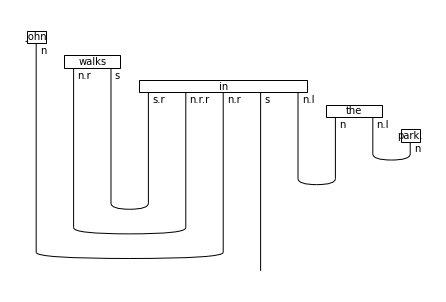

In [2]:
from lambeq import BobcatParser, DepCCGParser
from lambeq import TreeReader, TreeReaderMode
from discopy import grammar


# reader = BobcatParser(verbose='suppress')
sentence = 'John walks in the park.'
reader = DepCCGParser(root_cats=['S[dcl]'])
reader.sentence2diagram(sentence).draw()

# 0 : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 829.03it/s]

# 1 : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 918.74it/s]


Parse trees to diagrams:   0%|          | 0/70 [00:00<?, ?it/s]

# 0 : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 469.32it/s]

# 1 : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 504.25it/s]


Parse trees to diagrams:   0%|          | 0/30 [00:00<?, ?it/s]

# 0 : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 494.79it/s]

# 1 : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 507.64it/s]


Parse trees to diagrams:   0%|          | 0/30 [00:00<?, ?it/s]

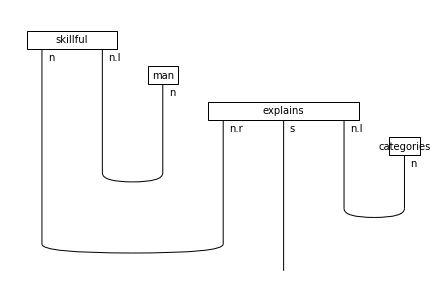

In [3]:
raw_train_diagrams = reader.sentences2diagrams(train_data)
raw_dev_diagrams = reader.sentences2diagrams(dev_data)
raw_test_diagrams = reader.sentences2diagrams(test_data)
raw_train_diagrams[1].draw()

**String diagram rewriting**

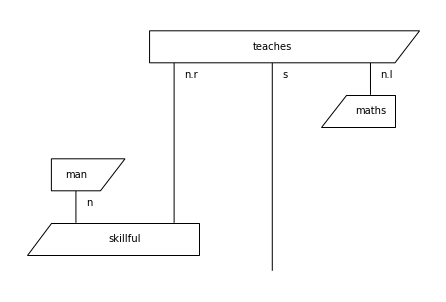

In [4]:
#from lambeq import remove_cups
from discopy.rigid import Id


def remove_cups(diagram):
    # Remove cups to reduce post-selection in the circuit, for faster execution

    diags = []
    for box, offset in zip(diagram.boxes, diagram.offsets):
        if not box.dom:  # word box
            diags.insert(offset, box)
        else:  # cup (the only other type of box in these diagrams)
            i = 0
            off = offset
            while off != len(diags[i].cod) - 1:
                assert off > 0
                off -= len(diags[i].cod)
                i += 1
            left, right = diags[i:i+2]
            
            if len(left.cod) == 1:
                new_diag = right >> (left.r.dagger() @ Id(right.cod[1:]))
            else:
                assert len(right.cod) == 1
                new_diag = left >> (Id(left.cod[:-1]) @ right.l.dagger())

            diags[i:i+2] = [new_diag]

    assert len(diags) == 1
    return diags[0]


train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

train_diagrams[0].draw()

**Conversion of each diagram into a quantum circuit**

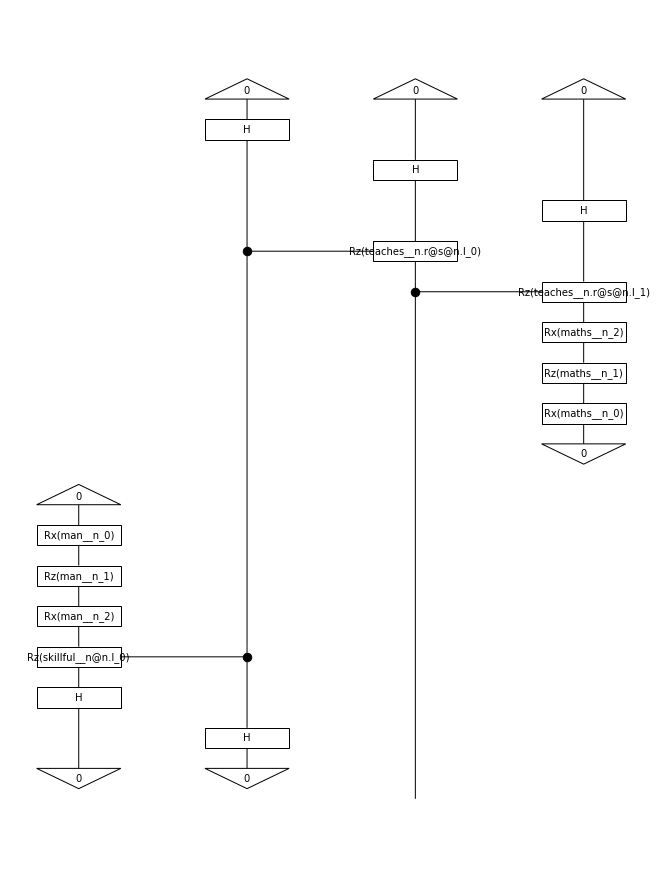

In [5]:
from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(9, 12))

**Sorting the symbols in quantum circuits to collect the parameters**

In [9]:
from sympy import default_sort_key

all_circuits = train_circuits + dev_circuits + test_circuits

# sort the symbols since they are returned as a set
parameters = sorted(
    {s for circ in all_circuits for s in circ.free_symbols},
    key=default_sort_key)

**Defining the quantum simulator**

In [10]:
## CONFIGURE BACKEND
# This uses Qiskit, which requires installing `pytket-qiskit`.
# For more information on how to use pytket with different backends, see:
# https://cqcl.github.io/pytket/build/html/extensions/

# Aer is a shots-based backend that is always available.

from pytket.extensions.qiskit import AerBackend
backend = AerBackend()

## Having an IBMQ account gives access to the IBM emulator for noisy simulations:
#
# from pytket.extensions.qiskit import IBMQEmulatorBackend
# backend = IBMQEmulatorBackend('PLACEHOLDER')
#
## To use a real device:
#
# from pytket.extensions.qiskit import IBMQBackend
# backend = IBMQBackend('PLACEHOLDER')

backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(1),
    'n_shots': 1024  # maximum recommended shots, reduces sampling error
}

2022-07-03 16:26:55,546 - INFO - qiskit.compiler.assembler - Total Assembly Time - 0.10443 (ms)
2022-07-03 16:26:55,548 - INFO - qiskit.compiler.assembler - Total Assembly Time - 0.08297 (ms)
2022-07-03 16:26:55,549 - INFO - qiskit.compiler.assembler - Total Assembly Time - 0.06962 (ms)
2022-07-03 16:26:55,549 - INFO - qiskit.compiler.assembler - Total Assembly Time - 0.08750 (ms)
2022-07-03 16:26:55,550 - INFO - qiskit.compiler.assembler - Total Assembly Time - 0.07176 (ms)
2022-07-03 16:26:55,551 - INFO - qiskit.compiler.assembler - Total Assembly Time - 0.06771 (ms)
2022-07-03 16:26:55,552 - INFO - qiskit.compiler.assembler - Total Assembly Time - 0.08464 (ms)
2022-07-03 16:26:55,553 - INFO - qiskit.compiler.assembler - Total Assembly Time - 0.06723 (ms)
2022-07-03 16:26:55,554 - INFO - qiskit.compiler.assembler - Total Assembly Time - 0.07796 (ms)
2022-07-03 16:26:55,555 - INFO - qiskit.compiler.assembler - Total Assembly Time - 0.06819 (ms)
2022-07-03 16:26:55,556 - INFO - qiskit.

**Making predictions from the quantum circuits**

In [11]:
from discopy.quantum import Circuit, Id, Measure


def randint(rng, low=-1 << 63, high=1 << 63-1):
    return rng.integers(low, high)


def normalise(predictions):
    # apply smoothing to predictions
    predictions = np.abs(predictions) + 1e-9
    return predictions / predictions.sum()


def make_pred_fn(circuits, rng):
    measured_circuits = [c >> Id().tensor(*[Measure()] * len(c.cod)) for c in circuits]
    circuit_fns = [c.lambdify(*parameters) for c in measured_circuits]

    def predict(params):
        outputs = Circuit.eval(*(c_fn(*params) for c_fn in circuit_fns),
                               **backend_config, seed=randint(rng))
        return np.array([normalise(output.array) for output in outputs])
    return predict


SEED = 0
rng = np.random.default_rng(SEED)

train_pred_fn = make_pred_fn(train_circuits, rng)
dev_pred_fn = make_pred_fn(dev_circuits, rng)
test_pred_fn = make_pred_fn(test_circuits, rng)

**Calculating cost function, accuracy and optimizing the circuit parameters**

In [12]:
from noisyopt import minimizeSPSA

def make_cost_fn(pred_fn, labels):
    def cost_fn(params, **kwargs):
        predictions = pred_fn(params)

        cost = -np.sum(labels * np.log(predictions)) / len(labels)  # binary cross-entropy loss
        costs.append(cost)

        acc = np.sum(np.round(predictions) == labels) / len(labels) / 2  # half due to double-counting
        accuracies.append(acc)

        return cost

    costs, accuracies = [], []
    return cost_fn, costs, accuracies


train_cost_fn, train_costs, train_accs = make_cost_fn(train_pred_fn, train_labels)
dev_cost_fn, dev_costs, dev_accs = make_cost_fn(dev_pred_fn, dev_labels)

x0 = np.array(rng.random(len(parameters)))
np.random.seed(SEED)
result = minimizeSPSA(train_cost_fn, x0=x0, a=0.2, c=0.06, niter=80, callback=dev_cost_fn)

2022-07-03 16:27:09,587 - INFO - qiskit.compiler.assembler - Total Assembly Time - 0.18644 (ms)
2022-07-03 16:27:13,503 - INFO - qiskit.compiler.assembler - Total Assembly Time - 0.24223 (ms)
2022-07-03 16:27:15,644 - INFO - qiskit.compiler.assembler - Total Assembly Time - 0.13280 (ms)
2022-07-03 16:27:19,328 - INFO - qiskit.compiler.assembler - Total Assembly Time - 0.22459 (ms)
2022-07-03 16:27:23,234 - INFO - qiskit.compiler.assembler - Total Assembly Time - 0.27990 (ms)
2022-07-03 16:27:25,406 - INFO - qiskit.compiler.assembler - Total Assembly Time - 0.13542 (ms)
2022-07-03 16:27:29,832 - INFO - qiskit.compiler.assembler - Total Assembly Time - 0.19240 (ms)
2022-07-03 16:27:33,808 - INFO - qiskit.compiler.assembler - Total Assembly Time - 0.20027 (ms)
2022-07-03 16:27:35,930 - INFO - qiskit.compiler.assembler - Total Assembly Time - 0.13709 (ms)
2022-07-03 16:27:39,561 - INFO - qiskit.compiler.assembler - Total Assembly Time - 0.19097 (ms)
2022-07-03 16:27:43,469 - INFO - qiskit.

**Plotting the training & development set results**

2022-07-03 16:41:07,223 - INFO - qiskit.compiler.assembler - Total Assembly Time - 0.13351 (ms)


Test accuracy: 0.7166666666666667


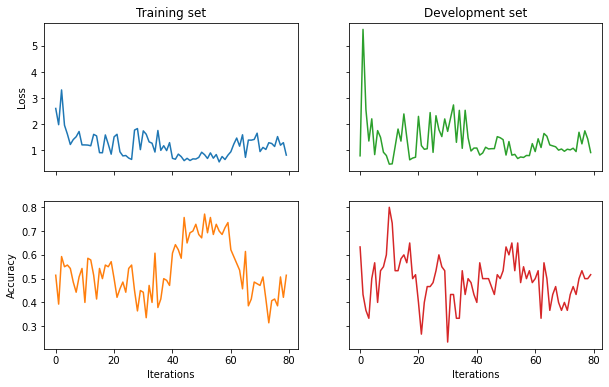

In [13]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(train_costs[1::2], color=next(colours))  # training evaluates twice per iteration
ax_bl.plot(train_accs[1::2], color=next(colours))   # so take every other entry
ax_tr.plot(dev_costs, color=next(colours))
ax_br.plot(dev_accs, color=next(colours))

# print test accuracy
test_cost_fn, _, test_accs = make_cost_fn(test_pred_fn, test_labels)
test_cost_fn(result.x)
print('Test accuracy:', test_accs[0])